In [1]:
import pandas as pd
import numpy as np

# !pip install pyhhmm
from pyhhmm.gaussian import GaussianHMM
# from hmmlearn.hmm import GaussianHMM
from pandas_datareader import data as pdr
import yfinance as yf
import matplotlib.pyplot as plt

### Structure Data

In [2]:
# Data Extraction

start_date = '2017-01-01'
end_date= '2022-06-01'
symbol = 'SPY'
yf.pdr_override()
# df = DataReader(name=symbol, data_source='yahoo', start=start_date, end=end_date)
df = pdr.get_data_yahoo(symbol, start=start_date, end=end_date)
data = df[["Open", "High", "Low", "Adj Close", "Volume"]]

[*********************100%***********************]  1 of 1 completed


In [3]:
df = data.copy()
df["Returns"] = (df["Adj Close"] / df["Adj Close"].shift(1)) - 1
df["Range"] = (df["High"]/df["Low"]) - 1
df.dropna(inplace=True)
print("Length: ", len(df))
df.head()

Length:  1361


,Open,High,Low,Adj Close,Volume,Returns,Range
Date,,,,,,,
2017-01-04,225.619995,226.750000,225.610001,202.535187,78744400,0.005949,0.005053
2017-01-05,226.270004,226.580002,225.479996,202.374283,78379000,-0.000794,0.004879
2017-01-06,226.529999,227.750000,225.899994,203.098312,71559900,0.003578,0.008189
2017-01-09,226.910004,227.070007,226.419998,202.427917,46939700,-0.003301,0.002871
2017-01-10,226.479996,227.449997,226.009995,202.427917,63771900,0.000000,0.006371


In [4]:
# Add Moving Average
df["MA_12"] = df["Adj Close"].rolling(window=12).mean()
df["MA_21"] = df["Adj Close"].rolling(window=21).mean()


In [5]:
# Structure Data
X_train = df[["Returns", "Range"]].iloc[:500]
X_test = df[["Returns", "Range"]].iloc[500:]
save_df = df.iloc[500:]


### Train HMM

In [6]:
model = GaussianHMM(n_states=4, covariance_type="full", n_emissions=2)
model.train([np.array(X_train.values)])
# model.predict([X_test.values])

f:\anaconda3\envs\statarb\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
f:\anaconda3\envs\statarb\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


(<pyhhmm.gaussian.GaussianHMM at 0x24c1feced50>, 3566.1153606735834)

In [7]:
df_main = save_df.copy()
df_main.drop(columns=["High", "Low"], inplace=True)

In [8]:
hmm_results     = model.predict([X_test.values])[0]
df_main["HMM"]  = hmm_results
df_main.head()

,Open,Adj Close,Volume,Returns,Range,MA_12,MA_21,HMM
Date,,,,,,,,
2018-12-31,249.559998,232.067383,144299400,0.008759,0.010991,231.581416,238.991984,3
2019-01-02,245.979996,232.308746,126925200,0.001040,0.021387,230.525218,238.009941,2
2019-01-03,248.229996,226.765244,144140700,-0.023863,0.020109,229.384022,236.690508,2
2019-01-04,247.589996,234.360916,142628800,0.033496,0.024032,229.268921,235.572319,2
2019-01-07,252.690002,236.208755,103139100,0.007885,0.016926,229.329344,234.939964,3


### Run Backtest

In [9]:
# Add MA Signals
df_main.loc[df_main["MA_12"] > df_main["MA_21"], "MA_Signal"] = 1
df_main.loc[df_main["MA_12"] <= df_main["MA_21"], "MA_Signal"] = 0


In [92]:
# Add HMM Signals
# Start with all HMM states, and we will remove the states that loss money after bactesting.
favourable_states = [0, 1]
hmm_values = df_main["HMM"].values
hmm_values = [1 if x in favourable_states else 0 for x in hmm_values]
df_main["HMM_Signal"] = hmm_values

In [93]:
# Add Combines Signal
df_main["Main_Signal"] = 0
df_main.loc[(df_main["MA_Signal"] == 1) & (df_main["HMM_Signal"] == 1), "Main_Signal"] = 1
df_main["Main_Signal"] = df_main["Main_Signal"].shift(1)

In [94]:
# Benchmark Returns
df_main["lrets_bench"] = np.log(df_main["Adj Close"]/df_main["Adj Close"].shift(1))
df_main["bench_prod"] = df_main["lrets_bench"].cumsum()
df_main["bench_prod_exp"] = np.exp(df_main["bench_prod"]) - 1

In [95]:
# Strategy Returns
# Always assume worst case senario
df_main["lrets_strat"] = np.log(df_main["Open"].shift(-1)/df_main["Open"]) * df_main["Main_Signal"]
df_main["lrets_prod"] = df_main["lrets_strat"].cumsum()
df_main["strat_prod_exp"] = np.exp(df_main["lrets_prod"]) - 1

In [96]:
# Review results table
df_main.dropna(inplace=True)
df_main.tail()

,Open,Adj Close,Volume,Returns,Range,MA_12,MA_21,HMM,MA_Signal,HMM_Signal,Main_Signal,lrets_bench,bench_prod,bench_prod_exp,lrets_strat,lrets_prod,strat_prod_exp
Date,,,,,,,,,,,,,,,,,
2022-05-10,404.489990,390.988678,132497200,0.002311,0.028519,406.903938,416.846266,2,0.0,0,0.0,0.002308,0.492160,0.635846,-0.0,0.338063,0.402229
2022-05-11,398.070007,384.777405,142361000,-0.015886,0.030820,403.984431,414.645672,2,0.0,0,0.0,-0.016014,0.476147,0.609859,-0.0,0.338063,0.402229
2022-05-12,389.369995,384.375732,125090800,-0.001044,0.027652,402.044624,412.501994,2,0.0,0,0.0,-0.001044,0.475102,0.608179,0.0,0.338063,0.402229
2022-05-13,396.709991,393.565338,104174400,0.023908,0.019135,400.775098,410.561723,2,0.0,0,0.0,0.023627,0.498729,0.646627,0.0,0.338063,0.402229
2022-05-16,399.980011,391.968414,78622400,-0.004058,0.016021,398.511991,408.802929,2,0.0,0,0.0,-0.004066,0.494663,0.639946,0.0,0.338063,0.402229


In [97]:
# Sharpe Ratio Function
def sharpe_ratio(returns_series):
    N = 255
    NSQRT = np.sqrt(N)
    rf = 0.01
    mean = returns_series.mean() * N
    sigma = returns_series.std() * NSQRT
    sharpe_ratio = round((mean - rf) / sigma, 2)
    return sharpe_ratio
    

In [98]:
# MEtrics
bench_rets = round(df_main["bench_prod_exp"].values[-1] * 100, 1)
strat_rets = round(df_main["strat_prod_exp"].values[-1] * 100, 1)

bench_sharpe = sharpe_ratio(df_main["lrets_bench"].values)
strat_sharpe = sharpe_ratio(df_main["lrets_strat"].values)

In [99]:
# Print Metrics
print(f"Returns Benchmark: {bench_rets}%")
print(f"Returns Strategy: {strat_rets}%")
print("--- --- --- --- ----")
print(f"Sharpe Benchmark: {bench_sharpe}")
print(f"Sharpe Strategy: {strat_sharpe}")



Returns Benchmark: 64.0%
Returns Strategy: 40.2%
--- --- --- --- ----
Sharpe Benchmark: 0.63
Sharpe Strategy: 1.2


### Plot Equity Curves

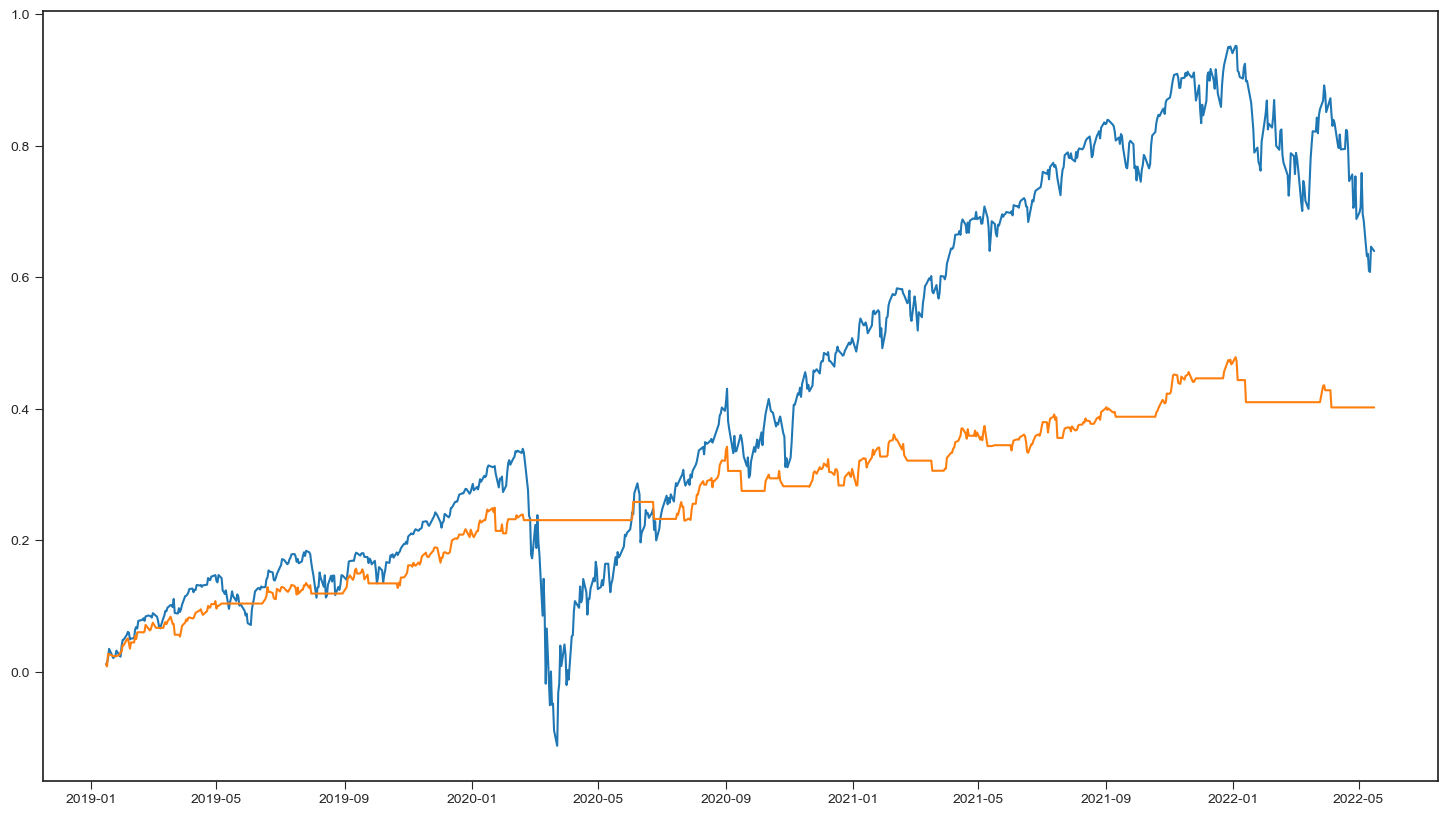

In [100]:
fig = plt.figure(figsize  = (18, 10))
plt.plot(df_main["bench_prod_exp"])
plt.plot(df_main["strat_prod_exp"])
plt.show()


### Save Data

In [101]:
# Save Data

df_main.to_csv("data/HMM_SPY.csv")